#Crédito

## Carregar base de Dados

In [32]:
# Importação dos pacotes
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Seed para reprodução de resultados
seed = 1
random.seed(seed)
np.random.seed(seed)

In [33]:
data = pd.read_table('credito.txt')
data.head()

,ESTC,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [34]:
data.shape

(2077, 12)

In [35]:
data.describe()

,ESTC,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
count,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000,2077.000000
mean,0.521907,0.122292,969.541647,0.447280,563.794415,8.395282,102.666346,0.128069,41.204622,30.901300,30.664420,0.474723
std,0.674420,0.556507,897.707359,0.497333,292.360830,3.614923,64.315987,0.334247,13.276082,51.960972,93.356164,0.499481
min,0.000000,0.000000,300.000000,0.000000,300.000000,1.000000,50.000000,0.000000,18.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,470.000000,0.000000,404.000000,6.000000,66.000000,0.000000,31.000000,6.000000,0.000000,0.000000
50%,0.000000,0.000000,640.000000,0.000000,489.000000,10.000000,83.000000,0.000000,39.000000,6.000000,0.000000,0.000000
75%,1.000000,0.000000,1150.000000,1.000000,618.000000,10.000000,118.000000,0.000000,52.000000,48.000000,0.000000,1.000000
max,3.000000,7.000000,9675.000000,1.000000,6000.000000,24.000000,719.000000,1.000000,70.000000,420.000000,1300.000000,1.000000


## Separar base em treino e teste

In [36]:
from sklearn.model_selection import train_test_split 
# Agora usaremos a função para fazer de fato a separação. Já faremos a separação em treino e teste e entrada e saída.
X = data.loc[:,data.columns != 'CLASSE']  # Entrada
y = data.CLASSE    # Saída
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [37]:
y.value_counts()

0    1091
1     986
Name: CLASSE, dtype: int64

In [38]:
# Verificar proporção para teste para confirmar amostragem estratificada
print(0.2*data.CLASSE.value_counts()[0])
print(0.2*data.CLASSE.value_counts()[1])

218.20000000000002
197.20000000000002


In [39]:
y_test.value_counts()

0    219
1    197
Name: CLASSE, dtype: int64

In [40]:
y_train.value_counts()

0    872
1    789
Name: CLASSE, dtype: int64

In [41]:
# Vamos olhar os shapes da bases de treino e teste
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1661, 11)
(416, 11)
(1661,)
(416,)


##Pré Processamento

###Missing

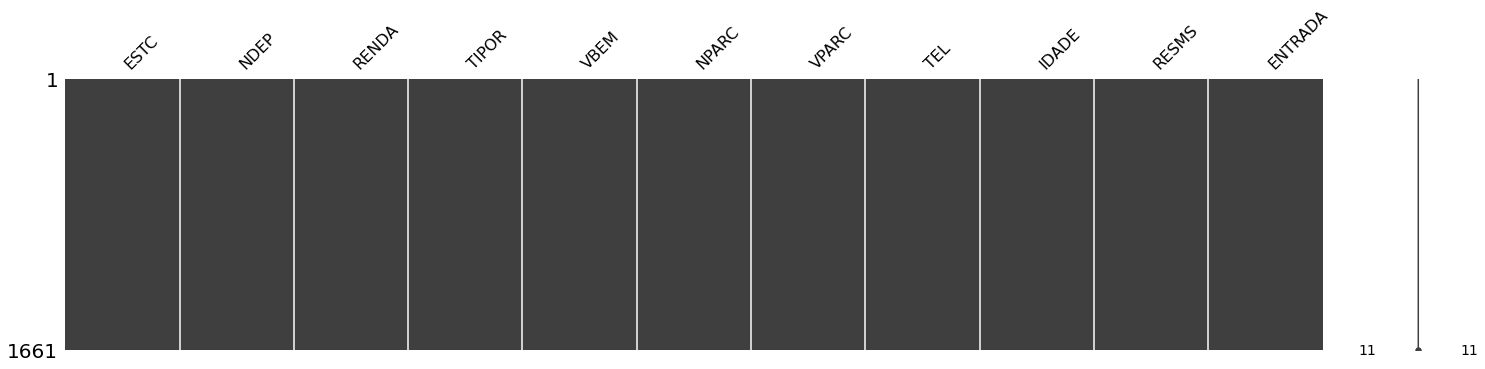

In [42]:
# Visualizar missing
import missingno as msno
msno.matrix(X_train, figsize=(25,5));

Não temos nenhum missing!

In [43]:
# remover colunas com variância zero
from sklearn.feature_selection import VarianceThreshold
zero_var_filter = VarianceThreshold()
X_train = zero_var_filter.fit_transform(X_train)

In [44]:
# colunas com variância zero
(zero_var_filter.variances_ == 0).sum()

0

In [45]:
# novo shape
X_train.shape

(1661, 11)

Não temos nenhuma coluna com variância zero!

##Machine Learning

In [46]:
# treinar modelo
from sklearn.svm import SVC

def trainSVM(X_train, y_train, seed):
  model = SVC(random_state=seed)
  model.fit(X_train, y_train)
  return model

model = trainSVM(X_train, y_train, seed)

### Avaliar modelo treinado na base de teste

In [47]:
# remover as mesmas colunas removidas por variância zero. Nesse caso não houveram tais atributos. Deixo o código caso tenham um caso que ocorra. Aqui não fará nenhuma diferença.
X_test = zero_var_filter.transform(X_test)
X_test.shape

(416, 11)

Acurácia:  0.5961538461538461
Kappa:  0.17873510540788262
F1:  0.5058823529411763


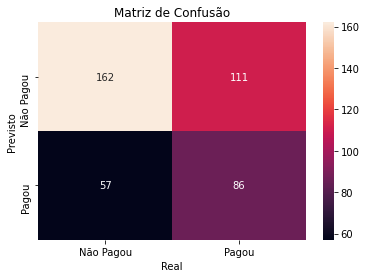

In [48]:
def predict_and_evaluate(X_test, y_test):

  # inferência do teste
  y_pred = model.predict(X_test) 

  # Acurácia
  from sklearn.metrics import accuracy_score
  accuracy = accuracy_score(y_test, y_pred)
  print('Acurácia: ', accuracy)

  # Kappa
  from sklearn.metrics import cohen_kappa_score
  kappa = cohen_kappa_score(y_test, y_pred)
  print('Kappa: ', kappa)

  # F1
  from sklearn.metrics import f1_score
  f1 = f1_score(y_test, y_pred)
  print('F1: ', f1)

  # Matriz de confusão
  from sklearn.metrics import confusion_matrix
  confMatrix = confusion_matrix(y_pred, y_test)

  ax = plt.subplot()
  sns.heatmap(confMatrix, annot=True, fmt=".0f")
  plt.xlabel('Real')
  plt.ylabel('Previsto')
  plt.title('Matriz de Confusão')

  # Colocar os nomes
  ax.xaxis.set_ticklabels(['Não Pagou', 'Pagou']) 
  ax.yaxis.set_ticklabels(['Não Pagou', 'Pagou'])
  plt.show()

predict_and_evaluate(X_test, y_test)

###Normalizar

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Acurácia:  0.8822115384615384
Kappa:  0.7611436606515116
F1:  0.8603988603988605


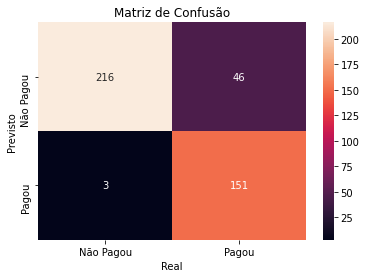

In [52]:
# Treinar e Testar novamente
model = trainSVM(X_train, y_train, seed)
predict_and_evaluate(X_test, y_test)

##Grid Search

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 0.5, 1],
                     'C': [1, 10, 100, 1000]}]
                     
print("# Tuning hyper-parameters for F1 score")
print()

model = GridSearchCV(SVC(), tuned_parameters, scoring='f1')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print()

# Tuning hyper-parameters for F1 score

              precision    recall  f1-score   support

           0       0.83      0.97      0.90       219
           1       0.96      0.78      0.86       197

    accuracy                           0.88       416
   macro avg       0.90      0.88      0.88       416
weighted avg       0.89      0.88      0.88       416




In [57]:
# Parâmetros do melhor modelo
model.best_estimator_

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Acurácia:  0.8822115384615384
Kappa:  0.7615125421190565
F1:  0.8627450980392157


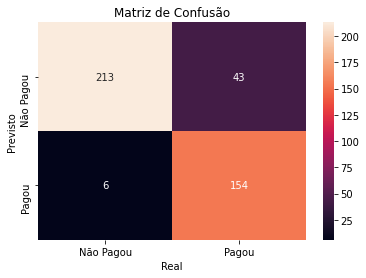

In [58]:
predict_and_evaluate(X_test, y_test)

# Salvar o modelo para produção

In [59]:
import pickle

In [62]:
file = open('svm_model', 'wb')
pickle.dump(model, file)

# Carregar o modelo para inferência (idealmente em outro script)

In [64]:
# Carregar modelo
file2 = open('svm_model', 'rb')
model2 = pickle.load(file2)

In [65]:
# carregar base
new_data = pd.read_table('credito_sem_rotulo.txt')
new_data.head()

,ESTC,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA
0,1,0,400,0,399,6,89,0,19,24,0
1,1,0,650,1,480,10,67,0,21,6,0
2,2,0,600,1,544,3,149,1,49,12,149
3,1,0,360,0,313,9,52,0,25,48,0
4,0,0,350,1,468,10,65,0,33,6,0


In [66]:
# pre processar
new_data = zero_var_filter.transform(new_data)
new_data = scaler.transform(new_data)

In [67]:
# inferir
model2.predict(new_data)

array([1, 1, 0, 1, 0, 0, 1, 1])